In [1]:
!pip install darts==0.16.1
from typing import Tuple, Sequence, Optional, Union, Dict
import math
from abc import ABC
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import weight_norm
from torch import Tensor
from darts import TimeSeries
from darts.logging import raise_if_not, get_logger
from darts.utils.likelihood_models import Likelihood
from darts.utils.torch import random_method
from darts.utils.likelihood_models import QuantileRegression, GaussianLikelihood
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
import numpy as np
from numpy.random.mtrand import RandomState
import pandas as pd
import matplotlib.pyplot as plt

from darts_utility import SolarFlare, SolarFlare_No_Attention, SolarFlare_No_Bigru

logger = get_logger(__name__)

     |████████████████████████████████| 326 kB 189 kB/s            
     |████████████████████████████████| 65 kB 1.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 1.4 MB 2.6 MB/s            
     |████████████████████████████████| 49 kB 3.2 MB/s             
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=9431977 sha256=615d723aca2e08b0e3733cbd249111dd0bac7855a22bcccb64811585ec054e94
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdst

In [9]:
path = '../input/irradiance-dataset/irradiance_dataset.csv'
df = pd.read_csv(path)[:43800*2]
df = df.drop(columns="Unnamed: 0")
memory = 24*6
horizon = 5
batch = 64

df.insert(0, 'GHI', df.pop('GHI'))

# Split data
target_ts = TimeSeries.from_series(df["GHI"]).astype(np.float32)
target_train, target_val = target_ts.split_after(0.8)


past_covar_ts = TimeSeries.from_dataframe(df[df.columns.to_list()[1:]]).astype(np.float32)
past_covar_train, past_covar_val = past_covar_ts.split_after(0.8)

# Scale data
target_ts_scaler = Scaler()
target_train = target_ts_scaler.fit_transform(target_train)
target_val = target_ts_scaler.transform(target_val)
series_transformed = target_ts_scaler.transform(target_ts)

covar_ts_scaler = Scaler()
covar_train = covar_ts_scaler.fit_transform(past_covar_train)
covar_val = covar_ts_scaler.transform(past_covar_val)


In [10]:
model1 = SolarFlare(input_chunk_length=memory,
                   kernel_size=2,
                   dilation_base=2,
                   output_chunk_length=horizon,
                   batch_size=batch,
                   hidden_size=100,
                   nr_epochs_val_period=1,
                   log_tensorboard=False,
                   likelihood=QuantileRegression(),
                   torch_device_str= "cuda")

model2 = SolarFlare_No_Attention(input_chunk_length=memory,
                   kernel_size=2,
                   dilation_base=2,
                   output_chunk_length=horizon,
                   likelihood=QuantileRegression(),
                   batch_size=batch,
                   hidden_size=128,
                   nr_epochs_val_period=1,
                   log_tensorboard=False,
                   torch_device_str= "cuda:0")

model3 = SolarFlare_No_Bigru(input_chunk_length=memory,
                   kernel_size=2,
                   dilation_base=2,
                   output_chunk_length=horizon,
                   likelihood=QuantileRegression(),
                   batch_size=batch,
                   hidden_size=128,
                   nr_epochs_val_period=1,
                   log_tensorboard=False,
                   torch_device_str= "cuda:0")

[2022-05-10 07:55:18,488] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 69932 samples.
[2022-05-10 07:55:18,488] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 69932 samples.
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
[2022-05-10 07:55:18,544] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-05-10 07:55:18,544] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/702 [00:00<?, ?it/s]

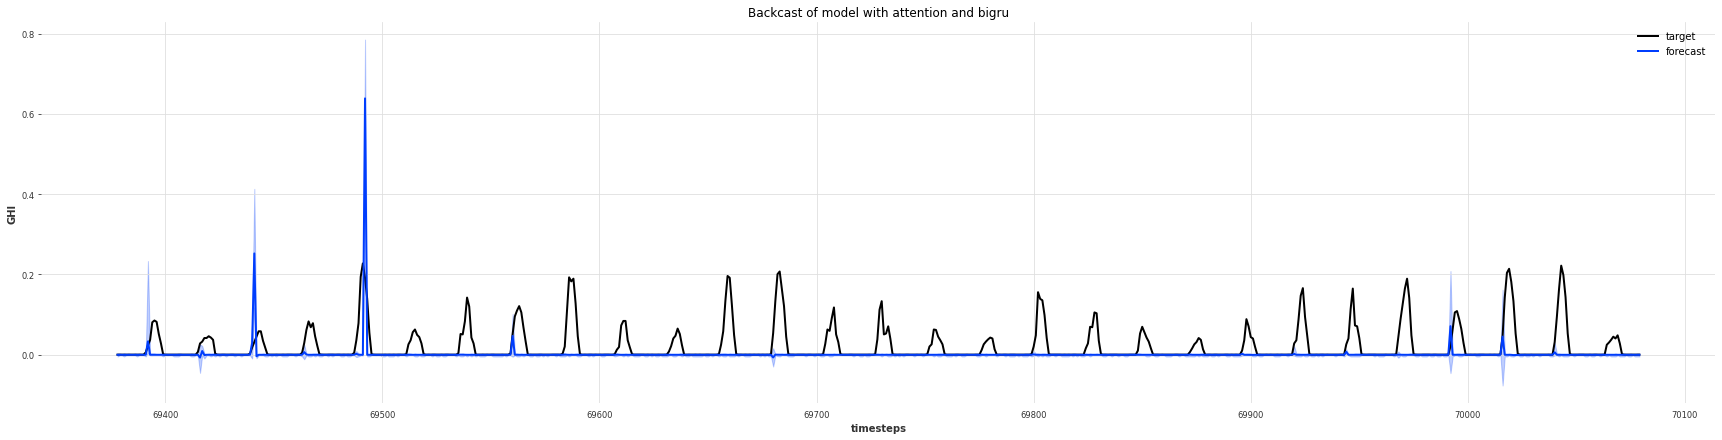

In [12]:
model1.fit(series=target_train, past_covariates=covar_train, val_series=target_val, val_past_covariates=covar_val, verbose=True, num_loader_workers=2)
model1.save_model("SolarFlare_bigru_attention83k.pth.tar")
plt.figure(figsize=(30, 7))
backcast1 = model1.historical_forecasts(series=target_train, past_covariates=past_covar_train, num_samples=600, start=0.99, retrain=False, verbose=True)
series_transformed.slice_intersect(backcast1).plot(label="target")
backcast1.plot(label="forecast")
plt.xlabel("timesteps")
plt.ylabel("GHI")
plt.title("Backcast of model with attention and bigru")
plt.legend()
plt.savefig("backcast1_bigru_attention83k.svg", format="svg")
plt.show()

In [ ]:
model2.fit(series=target_train, past_covariates=covar_train, val_series=target_val, val_past_covariates=covar_val, verbose=True, num_loader_workers=2)
model2.save_model("SolarFlare_no_attention.pth.tar")
plt.figure(figsize=(30, 7))
backcast2 = model2.historical_forecasts(series=target_train, past_covariates=past_covar_train, num_samples=300, start=0.97, retrain=False, verbose=True)
backcast2.quantile_df(quantile=0.5).to_csv("backcast2_no_attention.csv")
series_transformed.slice_intersect(backcast2).plot(label="target")
backcast2.plot(label="forecast", low_quantile=0.01, high_quantile=0.99)
plt.xlabel("timesteps")
plt.ylabel("GHI")
plt.title("Backcast of model with no attention")
plt.legend()
plt.savefig("backcast2_no_attention.svg", format="svg")
plt.show()

In [ ]:
model3.fit(series=target_train, past_covariates=covar_train, val_series=target_val, val_past_covariates=covar_val, verbose=True, num_loader_workers=2)
model3.save_model("SolarFlare_no_bigru.pth.tar")
backcast3 = model3.historical_forecasts(series=target_train, past_covariates=past_covar_train, num_samples=300, start=0.97, retrain=False, verbose=True)
backcast3.quantile_df(quantile=0.5).to_csv("backcast3_no_bigru.csv")
plt.figure(figsize=(20, 20))
series_transformed.slice_intersect(backcast3).plot(label="target")
backcast3.plot(label="forecast", low_quantile=0.01, high_quantile=0.99)
plt.xlabel("timesteps")
plt.ylabel("GHI")
plt.title("Backcast of model with no bidirectional gru")
plt.legend()
plt.savefig("backcast3_no_bigru.svg", format="svg")
plt.show()

In [ ]:
plt.figure(figsize=(30, 7))
series_transformed.slice_intersect(backcast1).plot(label="target")
backcast1.plot(label="forecast", low_quantile=0.01, high_quantile=0.99)
plt.xlabel("timesteps")
plt.ylabel("GHI")
plt.title("Backcast of model with attention and bigru")
plt.legend()
plt.savefig("backcast1_60k_bigru_attention.svg", format="svg")
plt.show()

  0%|          | 0/481 [00:00<?, ?it/s]

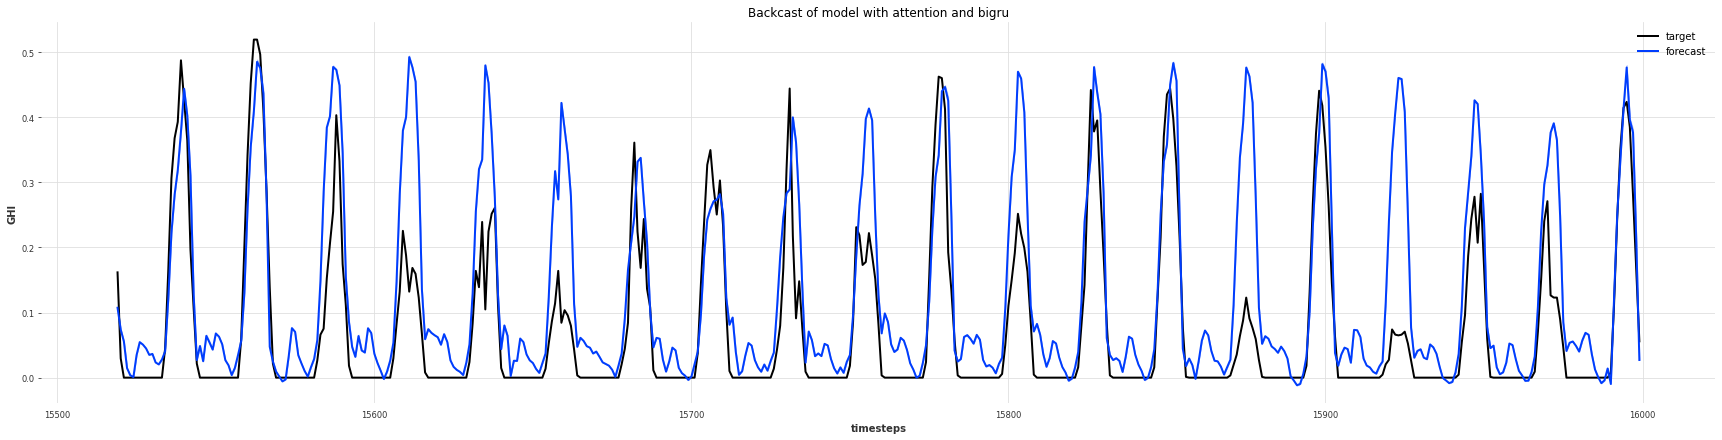

In [29]:
plt.figure(figsize=(30, 7))
backcast1 = model1.historical_forecasts(series=target_train, past_covariates=past_covar_train, num_samples=600, start=0.97, retrain=False, verbose=True)
series_transformed.slice_intersect(backcast1).plot(label="target")
backcast1.plot(label="forecast", low_quantile=0.1, high_quantile=0.9)
plt.xlabel("timesteps")
plt.ylabel("GHI")
plt.title("Backcast of model with attention and bigru")
plt.legend()
plt.savefig("backcast1_bigru_attention5.svg", format="svg")
plt.show()

  0%|          | 0/702 [00:00<?, ?it/s]

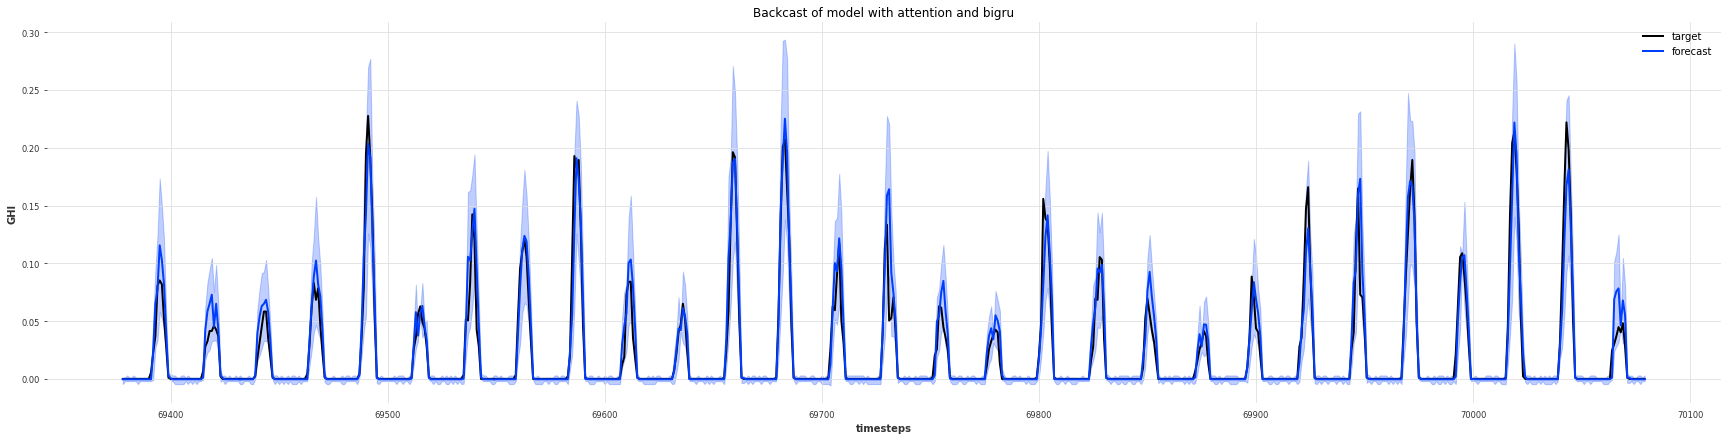

In [13]:
plt.figure(figsize=(30, 7))
backcast1 = model1.historical_forecasts(series=target_train, num_samples=600, start=0.99, retrain=False, verbose=True)
series_transformed.slice_intersect(backcast1).plot(label="target")
backcast1.plot(label="forecast")
plt.xlabel("timesteps")
plt.ylabel("GHI")
plt.title("Backcast of model with attention and bigru")
plt.legend()
plt.savefig("backcast1_bigru_attention83k.svg", format="svg")
plt.show()